Investigate the property derivative variation in the PHX space and how interval of P/H/X affect the derivation result.

In [1]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'  #default font family
mpl.rcParams['mathtext.fontset'] = 'cm' #font for math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from iapws import IAPWS97
import iapws

import pyswEOS
from pyswEOS import H2ONaCl
from pyswEOS import H2O
from pyswEOS import NaCl
water=H2O.cH2O()
sw=H2ONaCl.cH2ONaCl()
halite=NaCl.cNaCl()
figpath='.'
fmt_figs = ['jpg','svg','pdf']
path_echarts='../../manual/sphinx/source/Benchmarks/echarts/'

## Constant P and X, variable H

In [2]:
p, X_wt = 300E5, 0.032
H = np.linspace(200, 4000, 1000)*1000 #J/kg
Rho = np.zeros_like(H)
phaseRegion = np.zeros_like(H)
dRhodH = {}
dH_list = [1] #kJ/kg
for dH in dH_list:
    dRhodH[dH] = np.zeros_like(H)
for i in range(0, len(H)):
    prop = sw.prop_pHX(p, H[i], X_wt)
    Rho[i] = prop.Rho
    phaseRegion[i] = prop.Region
    for dH_kJ in dH_list:
        dH = float(dH_kJ)*1E3 #J/kg
        prop2 = sw.prop_pHX(p, H[i] + dH/2.0, X_wt)
        prop1 = sw.prop_pHX(p, H[i] - dH/2.0, X_wt)
        dRhodH[dH_kJ][i] = (prop2.Rho - prop1.Rho)/dH


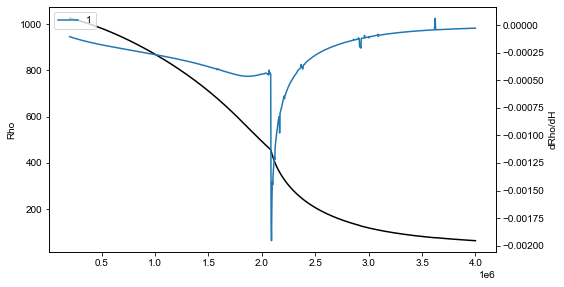

In [3]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(H, Rho,'k')
ax.set_ylabel('Rho')
# for i in range(1,len(phaseRegion)):
#     ax.axvspan(H[i-1], H[i], fc = plt.cm.tab10.colors[int(phaseRegion[i])], ec='None')

ax_der = ax.twinx()
for i, dH in enumerate(dH_list):
    ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
# ax_der.set_ylim(-0.0015, 0)
ax_der.set_ylabel('dRho/dH')
ax_der.legend()

plt.savefig('dRhodH.pdf', bbox_inches='tight')
plt.show()

## Constant P and X, variable T

* $\left( \frac{\partial \rho}{\partial H} \right)_{PX} = \left( \frac{\partial \rho /\partial T}{\partial H /\partial T} \right)_{PT}$

In [4]:
p, X_wt = 300E5, 0.032
T = np.linspace(1,800, 1000)+273.15 # K
H = np.zeros_like(T)
Rho = np.zeros_like(H)
phaseRegion = np.zeros_like(H)
dRhodT = {}
dHdT = {}
dRhodH = {}
dT_list = [0.000001] #K
for dT in dT_list:
    dRhodH[dT] = np.zeros_like(H)
    dRhodT[dT] = np.zeros_like(H)
    dHdT[dT] = np.zeros_like(H)
for i in range(0, len(T)):
    prop = sw.prop_pTX(p, T[i], X_wt)
    Rho[i] = prop.Rho
    H[i] = prop.H
    phaseRegion[i] = prop.Region
    for dT_K in dT_list:
        dT = float(dT_K) #K
        prop2 = sw.prop_pTX(p, T[i] + dT/2.0, X_wt)
        prop1 = sw.prop_pTX(p, T[i] - dH/2.0, X_wt)
        dRhodT[dT_K][i] = (prop2.Rho - prop1.Rho)/dT
        dHdT[dT_K][i] = (prop2.H - prop1.H)/dT
        dRhodH[dT_K][i] = dRhodT[dT_K][i]/dHdT[dT_K][i]


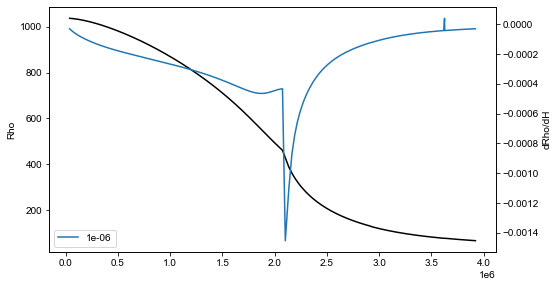

In [5]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(H, Rho,'k')
ax.set_ylabel('Rho')
# # for i in range(1,len(phaseRegion)):
# #     ax.axvspan(H[i-1], H[i], fc = plt.cm.tab10.colors[int(phaseRegion[i])], ec='None')

ax_der = ax.twinx()
for i, dH in enumerate(dT_list):
    ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
# # ax_der.set_ylim(-0.0015, 0)
ax_der.set_ylabel('dRho/dH')
ax_der.legend()

# plt.savefig('dRhodH.pdf', bbox_inches='tight')
plt.show()

## Test drho/dH of H2O using both formula and numerical difference methods
* Formula of $\left(\frac{\partial \rho}{\partial h}\right)_p = \left[ \left( \frac{\partial h}{\partial \rho} \right)_T - \left( \frac{\partial h}{\partial T} \right)_{\rho}\left( \frac{\partial p}{\partial \rho} \right)_T\left( \frac{\partial p}{\partial T} \right)_{\rho}^{-1} \right]^{-1}$, see [Thorade & Saadat (2013)](https://doi.org/10.1007/s12665-013-2394-z)
* All the derivatives inside the square brackets are already implemented in the [IAPWS95](https://iapws.readthedocs.io/en/latest/iapws.iapws95.html) python package. (dhdrho_T, dhdT_rho, dpdrho_T, dpdT_rho)

In [6]:
p = 30 # MPa
water=iapws.IAPWS95(T=1 + 273.15, P=30)
print(water.h)
water=iapws.IAPWS95(h=1500, P=p)
print(water.h, water.dhdrho_T, water.dhdT_rho, water.dpdrho_T, water.dpdT_rho)

33.94976586940974
1499.9999999999172 -0.6024177412086003 4.372360502197804 0.43334763458006287 0.9649333655996997


In [7]:
H = np.linspace(200, 4000, 100) #kJ/kg
Rho = np.zeros_like(H)
dRhodH = {}
dH_list = [1E-9, 1E-5, 1, 10] #kJ/kg
dRhodH_formula = np.zeros_like(H)
for dH in dH_list:
    dRhodH[dH] = np.zeros_like(H)
for i in range(0, len(H)):
    water=iapws.IAPWS95(h=H[i], P=p)
    Rho[i] = water.rho
    dRhodH_formula[i] = 1.0/(water.dhdrho_T - water.dhdT_rho * water.dpdrho_T / water.dpdT_rho)
    for dH_kJ in dH_list:
        dH = float(dH_kJ) #kJ/kg
        water2=iapws.IAPWS95(h=H[i]+dH/2, P=p)
        water1=iapws.IAPWS95(h=H[i]-dH/2, P=p)
        dRhodH[dH_kJ][i] = (water2.rho - water1.rho)/dH

/Users/zguo/miniconda3/lib/python3.9/site-packages/iapws/iapws95.py:2182: RuntimeWarning: invalid value encountered in double_scalars
  Tita = Tita**(1./3)
/Users/zguo/miniconda3/lib/python3.9/site-packages/iapws/iapws95.py:2213: RuntimeWarning: invalid value encountered in double_scalars
  Tita = Tita**(1./3)


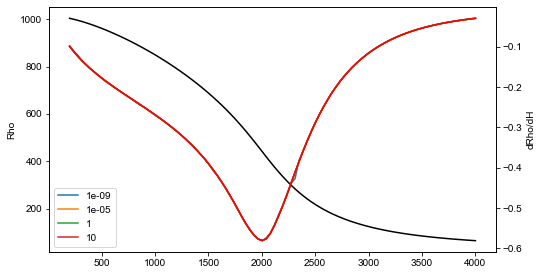

In [8]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(H, Rho,'k')
ax.set_ylabel('Rho')

ax_der = ax.twinx()
for i, dH in enumerate(dH_list):
    ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
ax_der.plot(H, dRhodH_formula, 'r')
# ax_der.set_ylim(-0.0015, 0)
ax_der.set_ylabel('dRho/dH')
ax_der.legend()

plt.savefig('dRhodH_water.pdf', bbox_inches='tight')
plt.show()

## Reconsider the derivative of H2ONaCl system

* **Molar volume** [$cm^3/mol$]: $V\left(P,T,X \right) = V_{H_2O}\left(T^*_{V}(P,T,X), P \right)$, where $T^*_V(P,T,X) = n_1(P,X) + n_2(P,X) T$ is the scaled temperature for volumetric correction
* **Density** [$kg/m^3$]: $\rho\left(P,T,X \right) = 1000\frac{M}{V(P,T,X)} = 1000 \frac{M}{V\left(T^*_{V}(P,T,X), P \right)}$
* **Partial density**: $\partial \rho(P,T,X) = -1000M\rho(P,T,X)^2 \partial V(P,T,X)$
* **Specific enthalpy** [$J/kg$]: $H\left(P,T,X \right) = H_{H_2O}\left(T^{*}_{H}(P,T,X), P \right)$, where $T^*_H(P,T,X) = q_1(P,X) + q_2(P,X) T$ is the scaled temperature for enthalpy correction


$$
\left ( \frac{\partial \rho(P,T,X)}{\partial H(P,T,X)} \right)_{PX} = -1000 M\rho(P,T,X)^2 \left ( \frac{\partial V(P,T,X)}{\partial H(P,T,X)} \right)_{PX} = -1000 M\rho(P,T,X)^2 \left( \frac{\partial V_{H_2O}(T^*_{V}) / \partial T^*_{V} \cdot \partial T^*_{V}/\partial T}{\partial H_{H_2O}(T^*_H) / \partial T^*_{H} \cdot \partial T^*_H /\partial T} \right)_{PX} = -1000 M\rho(P,T,X)^2 \left( \frac{A(T)}{B(T)} \frac{n_2(P,X)}{q_2(P,X)} \right)_{PX}
$$

* $A(T^*_V) = \left( \frac{\partial V_{H_2O}}{\partial T} \right)_P = - 10^{-3} \frac{M_{H_2O}}{\rho_{H_2O}^2} \left( \frac{\partial \rho_{H_2O}}{\partial T} \right)_P, (T = T^*_V)$
* $B(T^*_H) = \left( \frac{\partial H_{H_2O}}{\partial T} \right)_P, (T = T^*_H)$

1. Step 1: calculate $T^*_V$ and $T^*_H$ given (P,T,X)
2. Step2: calculate density of H2O-NaCl $\rho(T,P,X)$ given (P,T,X)
3. Step3: calculate $n_2, q_2$ given (P,X)
4. Step4: calculate ($A(T^*_V)$) `drhodT_P` of H2O given temperature value = $T^*_V$, this has been impplemented in the [IAPWS python package](https://iapws.readthedocs.io/en/latest/iapws.iapws95.html).
5. Step5: calculate ($B(T^*_H)$) `dhdT_P` of H2O given temperature value = $T^*_H$, this has been impplemented in the [IAPWS python package](https://iapws.readthedocs.io/en/latest/iapws.iapws95.html).

* Molality: Molality is a measure of the number of moles of solute in a solution corresponding to 1 kg or 1000 g of solvent. This contrasts with the definition of molarity which is based on a specified volume of solution. A commonly used unit for molality in chemistry is mol/kg.
* molal: $\frac{mol (NaCl)}{kg (H2O)}$

In [43]:
M_NaCl = 0.058443 # kg/mol
M_H2O = 0.018015 # kg/mol
wt2mol = lambda X_wt : X_wt/M_NaCl/(X_wt/M_NaCl + (1-X_wt)/M_H2O)
mol2wt = lambda X_mol : M_NaCl * X_mol / (M_NaCl * X_mol + (1 - X_mol) * M_H2O)
molal2mol = lambda X_molal : X_molal/(X_molal + 1/M_H2O)

n11 = lambda P : -54.2958 - 45.7623 * np.exp(-9.44785*1E-4*P)
n21 = lambda P : -2.6142 - 0.000239092 * P
n22 = lambda P : 0.0356828 + 4.37235 * 1E-6 * P + 2.0566 * 1E-9 * P**2
n20 = lambda P : 1 - n21(P) * np.sqrt(n22(P)) # derive from X = 0 -> T*_V = T
n10 = lambda P : 330.47 + 0.942876 * np.sqrt(P) + 0.0817193 * P - 2.47556 * 1E-8 * P**2 + 3.45052 * 1E-10 * P**3 # derive from X = 1, n10 = n1_X=1
n12 = lambda P : -n10(P) - n11(P)
n23 = lambda P : -0.0370751 + 0.00237723 * np.sqrt(P) + 5.42049 * 1E-5 * P + 5.84709 * 1E-9 * P**2 - 5.99373 * 1E-13 * P**3 - n20(P) - n21(P) * np.sqrt(1 + n22(P))

n300 = lambda P : 7.60664 * 1E6 /(P + 472.051)**2
n301 = lambda P : -50 - 86.1446 * np.exp(6.21128 * 1E-4 * P)
n302 = lambda P : 294.318 * np.exp(-5.66735 * 1E-3 * P)
n310 = lambda P : -0.0732761 * np.exp(-2.3772 * 1E-3 * P) - 5.2948 * 1E-5 * P
n311 = lambda P : -47.2747 + 24.3653 * np.exp(-1.25533 * 1E-3 * P)
n312 = lambda P : -0.278529 - 0.00081381 * P
o2 = lambda P : 2.0125 * 1E-7 + 3.29977 * 1E-9 * np.exp(-4.31279*np.log(P)) - 1.17748 * 1E-7 * np.log(P) + 7.58009 * 1E-8 *(np.log(P))**2
n1 = lambda P, X_mol : n10(P) + n11(P) * (1-X_mol) + n12(P) * (1 - X_mol)**2
n2 = lambda P, X_mol : n20(P) + n21(P) * np.sqrt(X_mol + n22(P)) + n23(P)*X_mol
n30 = lambda P, X_mol : n300(P) * (np.exp(n301(P) * X_mol) - 1) + n302(P) * X_mol
n31 = lambda P, X_mol : n310(P) * np.exp(n311(P) * X_mol) + n312(P) * X_mol
D = lambda T, P, X_mol : n30(P, X_mol) * np.exp(n31(P, X_mol)*T)

T_star_V = lambda T, P, X_mol: n1(P, X_mol) + n2(P, X_mol)*T + D(T, P, X_mol)

X_wt = 0.1
print(T_star_V(200, 1000, wt2mol(X_wt)))

196.52664305740234


0.018238254702195984


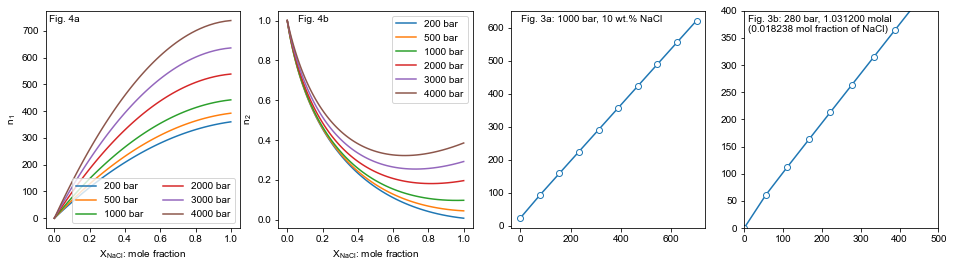

In [44]:
# check n1 and n2
X_wt = np.linspace(0,1,100)
X_mol = wt2mol(X_wt)

fig, axes = plt.subplots(1,4, figsize=(16,4))
ax_n1 = axes[0]
ax_n2 = axes[1]
for P in [200, 500, 1000, 2000, 3000, 4000]:
    ax_n1.plot(X_mol, n1(P, X_mol), label='%d bar'%P)
    ax_n2.plot(X_mol, n2(P, X_mol), label='%d bar'%P)
ax_n1.legend(ncol=2, loc='lower right')
ax_n2.legend()
ax_n1.set_xlabel('X$_{\mathregular{NaCl}}$: mole fraction')
ax_n1.set_ylabel('n$_{\mathregular{1}}$')
ax_n2.set_xlabel('X$_{\mathregular{NaCl}}$: mole fraction')
ax_n2.set_ylabel('n$_{\mathregular{2}}$')
ax_n1.text(0.02, 0.98, 'Fig. 4a', va='top', ha='left', transform=ax_n1.transAxes)
ax_n2.text(0.1, 0.98, 'Fig. 4b', va='top', ha='left', transform=ax_n2.transAxes)

# test T*_V
P, X_wt = 1000, 0.1
T = np.linspace(0, 700, 10)
T_star = T_star_V(T, P, wt2mol(X_wt))
ax = axes[2]
ax.plot(T, T_star, marker='o', mfc='w')
ax.text(0.05, 0.98, 'Fig. 3a: %d bar, %d wt.%% NaCl'%(P, X_wt*100), va='top', ha='left', transform=ax.transAxes)

X_molal = 1.0312
P, X_mol = 280, molal2mol(X_molal)
print(X_mol)
T = np.linspace(0, 500, 10)
T_star = T_star_V(T, P, X_mol)
ax = axes[3]
ax.plot(T, T_star, marker='o', mfc='w')
ax.text(0.02, 0.98, 'Fig. 3b: %d bar, %f molal\n(%f mol fraction of NaCl)'%(P, X_molal, X_mol), va='top', ha='left', transform=ax.transAxes)
ax.set_xlim(0, 500)
ax.set_ylim(0,400)

plt.show()

### Test rho

In [54]:
p, X_wt = 300E5, 0.032
T = np.linspace(1,800, 200)+273.15 # K
H = np.zeros_like(T)
Rho_H2O = np.zeros_like(H)
Rho = np.zeros_like(H)

# phaseRegion = np.zeros_like(H)
# dRhodT = {}
# dHdT = {}
# dRhodH = {}
# dT_list = [0.000001] #K
# for dT in dT_list:
#     dRhodH[dT] = np.zeros_like(H)
#     dRhodT[dT] = np.zeros_like(H)
#     dHdT[dT] = np.zeros_like(H)
T_star = T_star_V(T, P/1E5, wt2mol(X_wt))
for i in range(0, len(T)):
    water=iapws.IAPWS95(T = T_star[i], P=p/1E6)
    Rho_H2O[i] = water.rho
    prop = sw.prop_pTX(p, T[i], X_wt)
    Rho[i] = prop.Rho
V_H2O = 1.0/Rho_H2O * M_H2O # m^3/mol
V = V_H2O 
Rho_newCal = (M_NaCl * wt2mol(X_wt) + (1 - wt2mol(X_wt))*M_H2O)/V # kg/m^3


/Users/zguo/miniconda3/lib/python3.9/site-packages/iapws/iapws95.py:426: UserWarning: Using extrapolated values
  warnings.warn("Using extrapolated values")


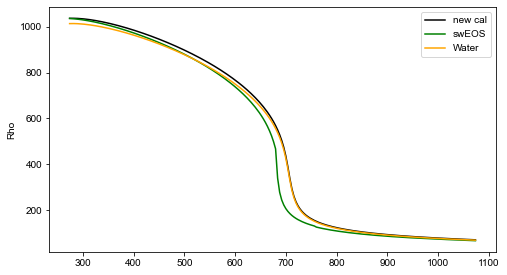

In [58]:
fig = plt.figure(figsize=(8, 4.5))
ax  = plt.gca()

ax.plot(T, Rho_newCal,'k', label = 'new cal')
ax.plot(T, Rho, 'g', label = 'swEOS')
ax.plot(T, Rho_H2O, 'orange', label='Water')
ax.set_ylabel('Rho')
ax.legend()
# # for i in range(1,len(phaseRegion)):
# #     ax.axvspan(H[i-1], H[i], fc = plt.cm.tab10.colors[int(phaseRegion[i])], ec='None')

# ax_der = ax.twinx()
# for i, dH in enumerate(dT_list):
#     ax_der.plot(H, dRhodH[dH], ms=1, label=dH)
# # # ax_der.set_ylim(-0.0015, 0)
# ax_der.set_ylabel('dRho/dH')
# ax_der.legend()

# plt.savefig('dRhodH.pdf', bbox_inches='tight')
plt.show()